In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from datetime import datetime, timedelta
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, SeasonalNaive, Naive, SimpleExponentialSmoothingOptimized, SeasonalExponentialSmoothingOptimized
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error as rmse
from geopy.distance import geodesic
import matplotlib.ticker as mticker

warnings.filterwarnings(
    "ignore",
    message="'force_all_finite' was renamed to 'ensure_all_finite'",
    category=FutureWarning,
    module="sklearn.utils.deprecation"
)
#Load the data
df=pd.read_csv('PEMS-BAY.csv',parse_dates=[0],index_col=[0])
#Filling the hour missing because of the time change
df_fill=df.reindex(pd.date_range('2017-03-12 02:00:00', '2017-03-12 03:00:00', freq='5min'),method='ffill')
df=df_fill.combine_first(df)
#Filling missing data
df.loc['2017-05-09 20:35:00']=(df.loc['2017-05-09 20:30:00']+df.loc['2017-05-09 20:40:00'])*0.5
df.loc['2017-05-05 19:55:00']=(df.loc['2017-05-05 19:50:00']+df.loc['2017-05-05 20:00:00'])*0.5
df.loc['2017-04-20 01:40:00']=(df.loc['2017-04-20 01:35:00']+df.loc['2017-04-20 01:45:00'])*0.5
#Reading meta data and computing the distance between sensors
meta=pd.read_csv('PEMS-BAY-META.csv')
total_sensor_num=len(meta)
dist=np.zeros([total_sensor_num,total_sensor_num])
for i in range(total_sensor_num):
    for j in range(i+1,total_sensor_num):
        dist[i][j]=geodesic((meta['Latitude'].iloc[i],meta['Longitude'].iloc[i]),(meta['Latitude'].iloc[j],meta['Longitude'].iloc[j])).kilometers
        dist[j][i]=dist[i][j]
df

,400001,400017,400030,400040,400045,400052,400057,400059,400065,400069,...,409525,409526,409528,409529,413026,413845,413877,413878,414284,414694
2017-01-01 00:00:00,71.4,67.8,70.5,67.4,68.8,66.6,66.8,68.0,66.8,69.0,...,68.8,67.9,68.8,68.0,69.2,68.9,70.4,68.8,71.1,68.0
2017-01-01 00:05:00,71.6,67.5,70.6,67.5,68.7,66.6,66.8,67.8,66.5,68.2,...,68.4,67.3,68.4,67.6,70.4,68.8,70.1,68.4,70.8,67.4
2017-01-01 00:10:00,71.6,67.6,70.2,67.4,68.7,66.1,66.8,67.8,66.2,67.8,...,68.4,67.4,68.4,67.5,70.2,68.3,69.8,68.4,70.5,67.9
2017-01-01 00:15:00,71.1,67.5,70.3,68.0,68.5,66.7,66.6,67.7,65.9,67.8,...,68.5,67.5,68.5,67.5,70.4,68.7,70.2,68.4,70.8,67.6
2017-01-01 00:20:00,71.7,67.8,70.2,68.1,68.4,66.9,66.1,67.7,66.1,67.8,...,68.5,67.7,68.5,67.4,69.6,69.1,70.0,68.4,71.0,67.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-30 23:35:00,70.9,66.3,68.4,61.0,61.8,66.9,66.0,67.4,65.4,69.3,...,64.6,66.8,64.7,61.1,68.4,61.4,70.5,68.2,71.6,66.2
2017-06-30 23:40:00,71.3,66.6,68.7,60.9,62.0,66.2,66.5,68.2,64.9,69.1,...,65.1,67.3,64.8,60.8,69.8,62.2,69.4,68.6,71.6,68.4
2017-06-30 23:45:00,71.4,66.9,68.1,61.1,62.0,66.7,65.8,68.2,64.2,69.1,...,64.9,66.5,64.6,61.3,69.5,63.8,70.6,68.4,71.6,66.6
2017-06-30 23:50:00,72.2,66.5,68.0,61.1,62.5,65.8,67.1,68.3,64.0,67.3,...,64.1,65.9,64.8,61.3,69.6,64.2,70.2,68.7,71.6,68.4


In [2]:
#Setting train/validation/test spit parameters
train_weeks_num=10
valid_weeks_num=1
test_weeks_num=2
weeks=train_weeks_num+valid_weeks_num+test_weeks_num
blocks_num=4
sensors_num_block=5
sensors_num=blocks_num*sensors_num_block
neighbors_num=4
beginning=pd.to_datetime('2017-02-26 00:00:00')
df_all=df.loc[beginning:beginning+timedelta(weeks=weeks,minutes=-5)]

In [3]:
#Making the df for seasonal differences and historical average
df_diff=df_all.diff(2016).dropna()
df_hist=df_all.copy()
for i in range(2016):
    avg=df_all.iloc[i:2016*train_weeks_num:2016].mean()
    for j in range(weeks):
        df_hist.iloc[i+j*2016]=avg
df_histdiff=df_all-df_hist

In [4]:
#Making df for train, validation and test
df_train_all=df_all.loc[beginning:beginning+timedelta(weeks=train_weeks_num,minutes=-5)]
df_valid_all=df_all.loc[beginning+timedelta(weeks=train_weeks_num):beginning+timedelta(weeks=train_weeks_num+valid_weeks_num,minutes=-5)]
df_tv_all=df_all.loc[beginning:beginning+timedelta(weeks=train_weeks_num+valid_weeks_num,minutes=-5)]
df_test_all=df_all.loc[beginning+timedelta(weeks=train_weeks_num+valid_weeks_num):beginning+timedelta(weeks=weeks,minutes=-5)]
df_train_all_diff=df_diff.loc[beginning:beginning+timedelta(weeks=train_weeks_num,minutes=-5)]
df_valid_all_diff=df_diff.loc[beginning+timedelta(weeks=train_weeks_num):beginning+timedelta(weeks=train_weeks_num+valid_weeks_num,minutes=-5)]
df_tv_all_diff=df_diff.loc[beginning:beginning+timedelta(weeks=train_weeks_num+valid_weeks_num,minutes=-5)]
df_test_all_diff=df_diff.loc[beginning+timedelta(weeks=train_weeks_num+valid_weeks_num):beginning+timedelta(weeks=weeks,minutes=-5)]
df_train_all_hist=df_hist.loc[beginning:beginning+timedelta(weeks=train_weeks_num,minutes=-5)]
df_valid_all_hist=df_hist.loc[beginning+timedelta(weeks=train_weeks_num):beginning+timedelta(weeks=train_weeks_num+valid_weeks_num,minutes=-5)]
df_tv_all_hist=df_hist.loc[beginning:beginning+timedelta(weeks=train_weeks_num+valid_weeks_num,minutes=-5)]
df_test_all_hist=df_hist.loc[beginning+timedelta(weeks=train_weeks_num+valid_weeks_num):beginning+timedelta(weeks=weeks,minutes=-5)]
df_train_all_histdiff=df_histdiff.loc[beginning:beginning+timedelta(weeks=train_weeks_num,minutes=-5)]
df_valid_all_histdiff=df_histdiff.loc[beginning+timedelta(weeks=train_weeks_num):beginning+timedelta(weeks=train_weeks_num+valid_weeks_num,minutes=-5)]
df_tv_all_histdiff=df_histdiff.loc[beginning:beginning+timedelta(weeks=train_weeks_num+valid_weeks_num,minutes=-5)]
df_test_all_histdiff=df_histdiff.loc[beginning+timedelta(weeks=train_weeks_num+valid_weeks_num):beginning+timedelta(weeks=weeks,minutes=-5)]

In [5]:
#Computing the avrage speed of sensors by time and day of the week
avg_speed=[]
for k in range(total_sensor_num):
    row=[np.array([df_train_all[df.columns[k]].loc[beginning+timedelta(minutes=5*j,weeks=i)] for i in range(train_weeks_num)]).mean() for j in range(2016)]
    row.append(meta['Latitude'].iloc[k])
    row.append(meta['Longitude'].iloc[k])
    avg_speed.append(row)
cols=pd.date_range(beginning,beginning+timedelta(weeks=1,minutes=-5),freq='5min')
cols=cols.strftime("%A %H:%M").to_numpy()
cols=np.append(cols,['Latitude','Longitude'])
avg_speed=pd.DataFrame(avg_speed,columns=np.array(cols))
avg_speed['sensor_id']=df.columns
avg_speed_weekday=[]
for k in range(total_sensor_num):
    row=[np.array([avg_speed.iloc[k,j+i*288] for i in range(1,6)]).mean() for j in range(288)]
    row.append(meta['Latitude'].iloc[k])
    row.append(meta['Longitude'].iloc[k])
    avg_speed_weekday.append(row)
cols=pd.date_range(beginning,beginning+timedelta(days=1,minutes=-5),freq='5min')
cols=cols.strftime("%H:%M").to_numpy()
cols=np.append(cols,['Latitude','Longitude'])
avg_speed_weekday=pd.DataFrame(avg_speed_weekday,columns=np.array(cols))
avg_speed_weekday['sensor_id']=df.columns
avg_speed_weekend=[]
for k in range(total_sensor_num):
    row=[np.array([avg_speed.iloc[k,j+i*288] for i in [0,6]]).mean() for j in range(288)]
    row.append(meta['Latitude'].iloc[k])
    row.append(meta['Longitude'].iloc[k])
    avg_speed_weekend.append(row)
cols=pd.date_range(beginning,beginning+timedelta(days=1,minutes=-5),freq='5min')
cols=cols.strftime("%H:%M").to_numpy()
cols=np.append(cols,['Latitude','Longitude'])
avg_speed_weekend=pd.DataFrame(avg_speed_weekend,columns=np.array(cols))
avg_speed_weekend['sensor_id']=df.columns

In [6]:
#Making an animated map for average speed
avg_speed_long_weekday=avg_speed_weekday.melt(
    id_vars=['sensor_id','Latitude','Longitude'],
    value_vars=[c for c in avg_speed_weekday.columns if c not in ['sensor_id','Latitude','Longitude']],
    var_name='time_str',
    value_name='speed',
)
avg_speed_long_weekend=avg_speed_weekend.melt(
    id_vars=['sensor_id','Latitude','Longitude'],
    value_vars=[c for c in avg_speed_weekend.columns if c not in ['sensor_id','Latitude','Longitude']],
    var_name='time_str',
    value_name='speed',
)
fig = px.scatter_mapbox(
    avg_speed_long_weekday,
    lat="Latitude",
    lon="Longitude",
    color="speed",
    animation_frame="time_str",
    animation_group="sensor_id",
    color_continuous_scale=["red", "green"],
    hover_name="sensor_id",
    hover_data={"speed":":.2f", "Latitude":False, "Longitude":False},
    mapbox_style="open-street-map",
    zoom=11,
    height=750,
    range_color=[avg_speed_long_weekday["speed"].min(), avg_speed_long_weekday["speed"].max()],  # stable color scale
)
fig.update_traces(marker=dict(size=14))
fig.write_html("sensor_speed_animation_weekday.html", auto_play=False)
fig = px.scatter_mapbox(
    avg_speed_long_weekend,
    lat="Latitude",
    lon="Longitude",
    color="speed",
    animation_frame="time_str",
    animation_group="sensor_id",
    color_continuous_scale=["red", "green"],
    hover_name="sensor_id",
    hover_data={"speed":":.2f", "Latitude":False, "Longitude":False},
    mapbox_style="open-street-map",
    zoom=11,
    height=750,
    range_color=[avg_speed_long_weekend["speed"].min(), avg_speed_long_weekend["speed"].max()],  # stable color scale
)
fig.update_traces(marker=dict(size=14))
fig.write_html("sensor_speed_animation_weekend.html", auto_play=False)

In [7]:
#Selecting sensors for training, making corresponding dfs
df_selected=df.sample(n=sensors_num,axis=1,random_state=42)
sensors=df_selected.columns
sensors_orders=df.columns.get_indexer(df_selected.columns)
df_train=df_train_all[sensors]
df_valid=df_valid_all[sensors]
df_tv=df_tv_all[sensors]
df_test=df_test_all[sensors]
df_train_diff=df_train_all_diff[sensors]
df_valid_diff=df_valid_all_diff[sensors]
df_tv_diff=df_tv_all_diff[sensors]
df_test_diff=df_test_all_diff[sensors]
df_train_hist=df_train_all_hist[sensors]
df_valid_hist=df_valid_all_hist[sensors]
df_tv_hist=df_tv_all_hist[sensors]
df_test_hist=df_test_all_hist[sensors]
df_train_histdiff=df_train_all_histdiff[sensors]
df_valid_histdiff=df_valid_all_histdiff[sensors]
df_tv_histdiff=df_tv_all_histdiff[sensors]
df_test_histdiff=df_test_all_histdiff[sensors]

In [8]:
#Making functions to convert df from usual layout to the layout for StatsForecast
def sfdf(df):
    df_copy=df.copy()
    df_copy.index.name='ds'
    return df_copy.reset_index().melt(id_vars='ds',var_name='unique_id',value_name='y').sort_values(['unique_id','ds']).reset_index(drop=True)
def sfdfX(dff_all,dff_selected):
    df_all_shift=df_all.shift(1)
    selected_sensors=dff_selected.columns
    sensor=selected_sensors[0]
    sensor_ord=df.columns.get_indexer([sensor])[0]
    df_X=dff_all[neighbors[sensor_ord]].copy()
    df_X.columns=range(neighbors_num)
    df_X.insert(0, 'unique_id', sensor)
    df_X.insert(1, 'y', dff_selected[sensor].values)
    df_X.index.name='ds'
    df_X=df_X.reset_index()
    for i in range(1,len(selected_sensors)):
        sensor=selected_sensors[i]
        sensor_ord=df.columns.get_indexer([sensor])[0]
        arr=dff_all[neighbors[sensor_ord]].copy()
        arr.columns=range(neighbors_num)
        arr.insert(0, 'unique_id', sensor)
        arr.insert(1, 'y', dff_selected[sensor].values)
        arr.index.name='ds'
        arr=arr.reset_index()
        df_X=pd.concat([df_X,arr])
    return df_X
sfdf(df_train)

,ds,unique_id,y
0,2017-02-26 00:00:00,400052,67.4
1,2017-02-26 00:05:00,400052,67.9
2,2017-02-26 00:10:00,400052,66.9
3,2017-02-26 00:15:00,400052,66.9
4,2017-02-26 00:20:00,400052,66.2
...,...,...,...
403195,2017-05-06 23:35:00,413845,61.9
403196,2017-05-06 23:40:00,413845,62.6
403197,2017-05-06 23:45:00,413845,60.6
403198,2017-05-06 23:50:00,413845,60.9


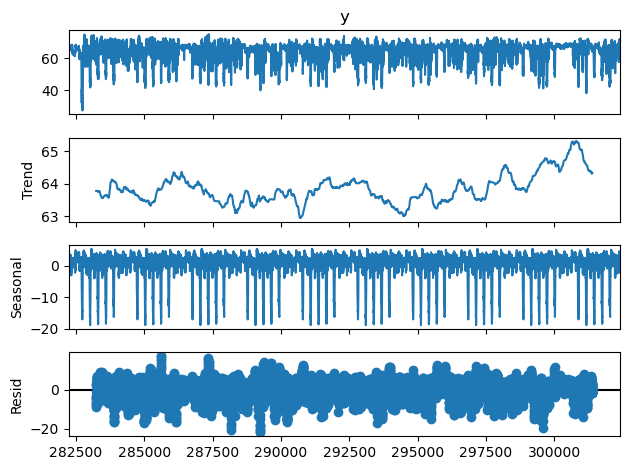

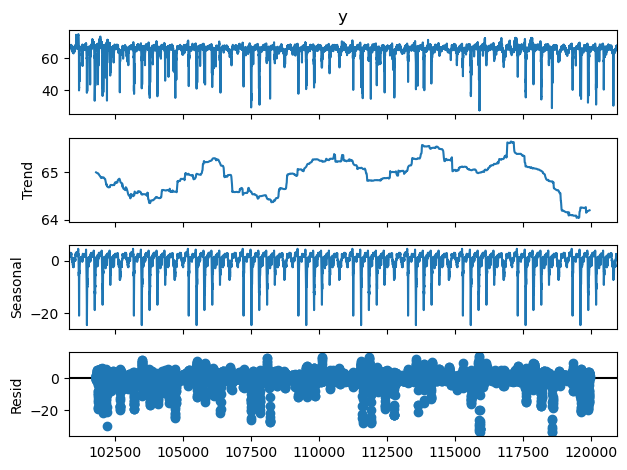

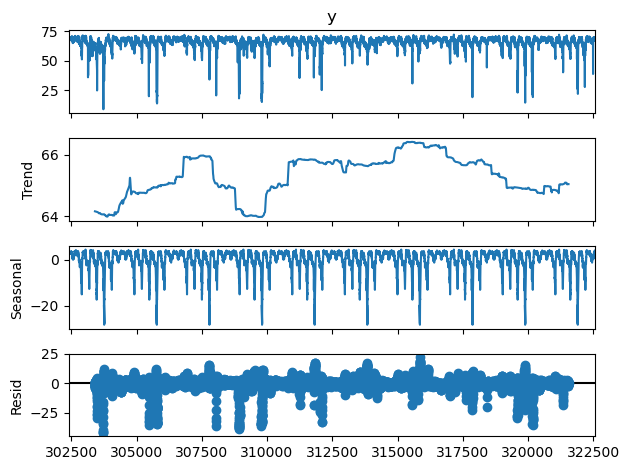

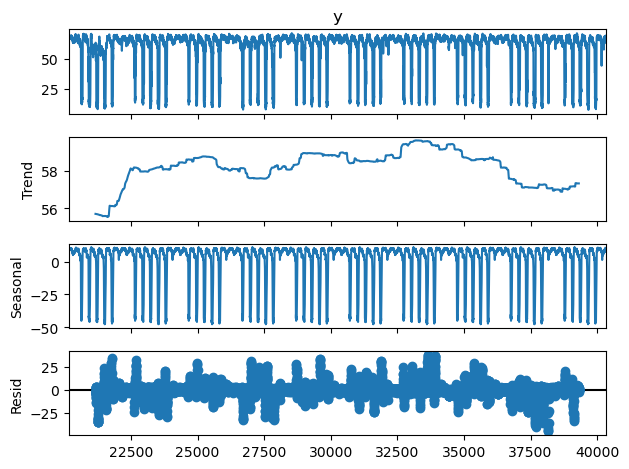

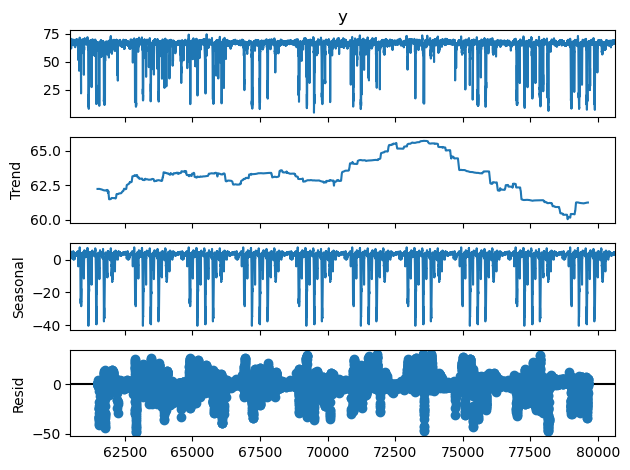

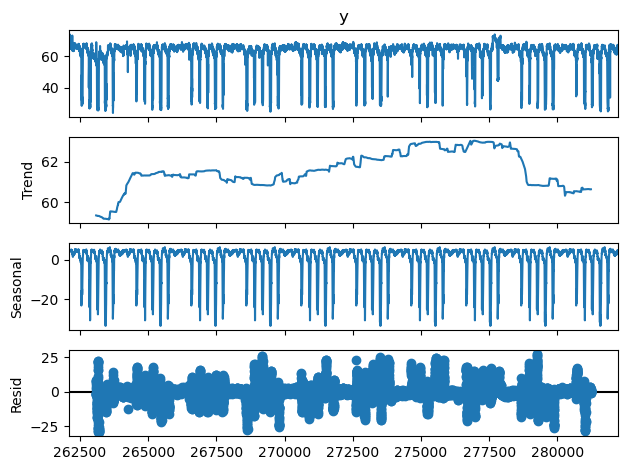

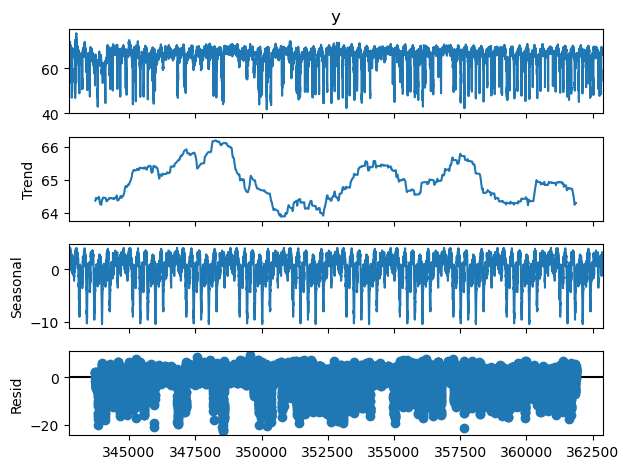

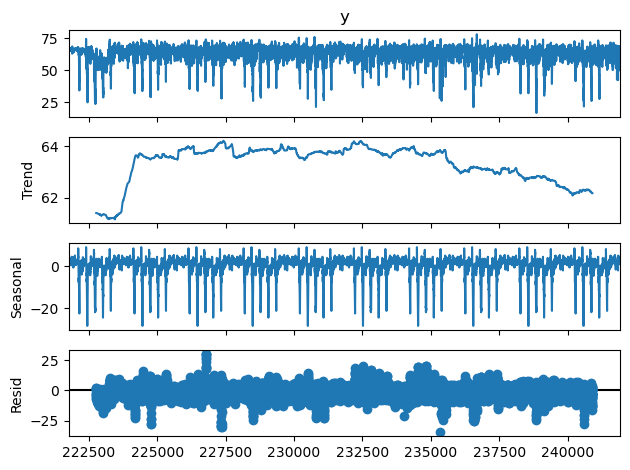

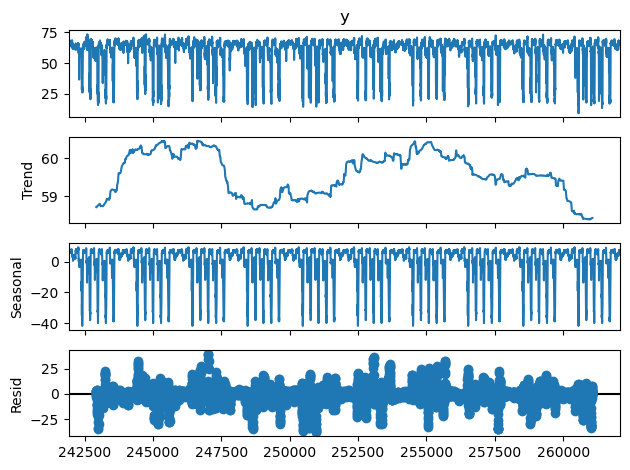

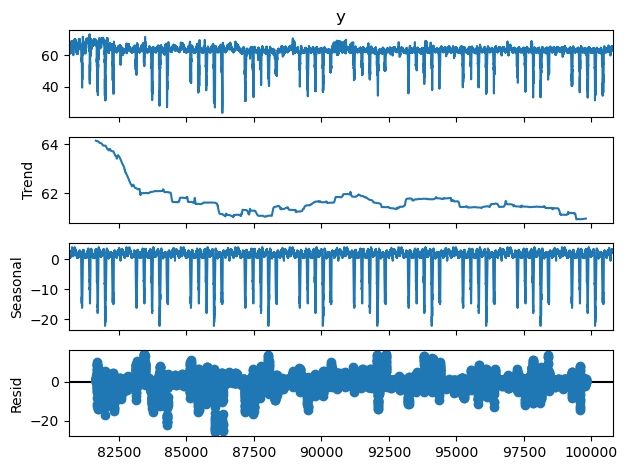

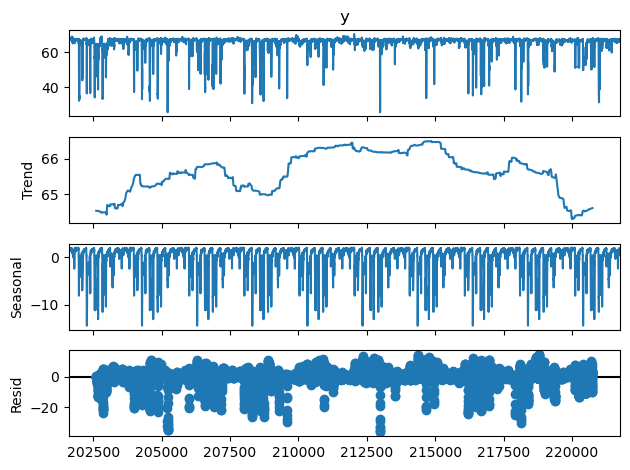

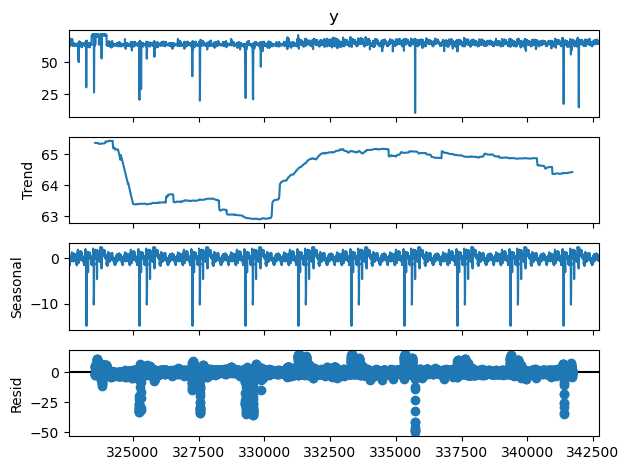

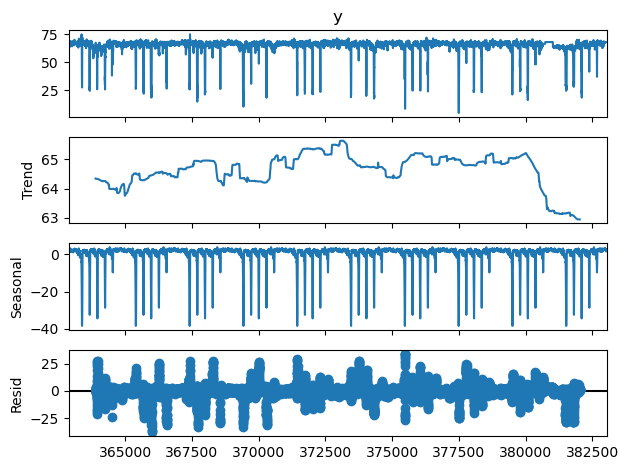

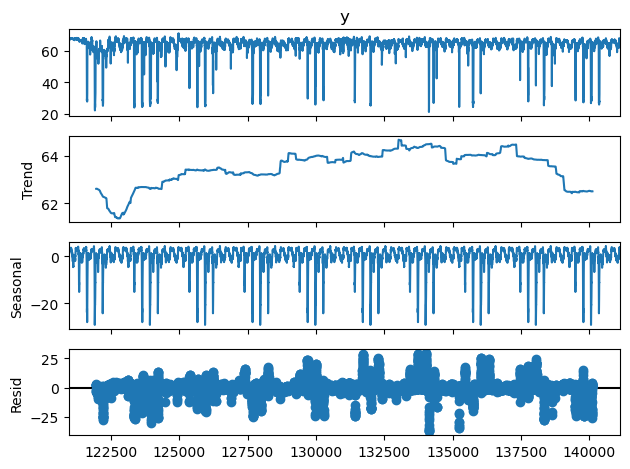

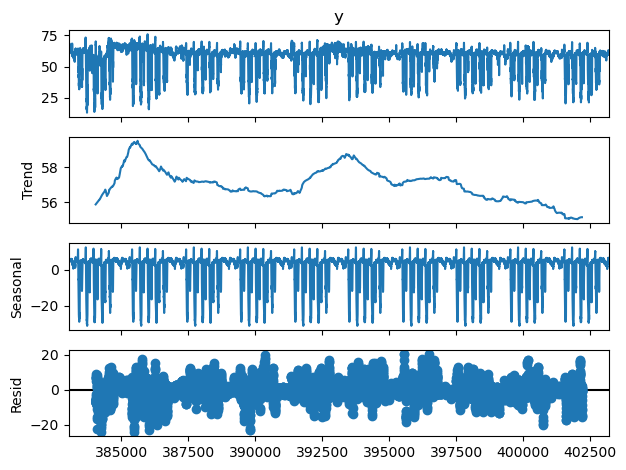

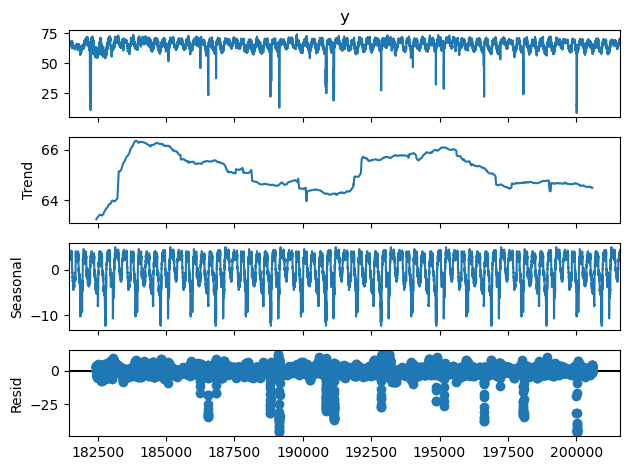

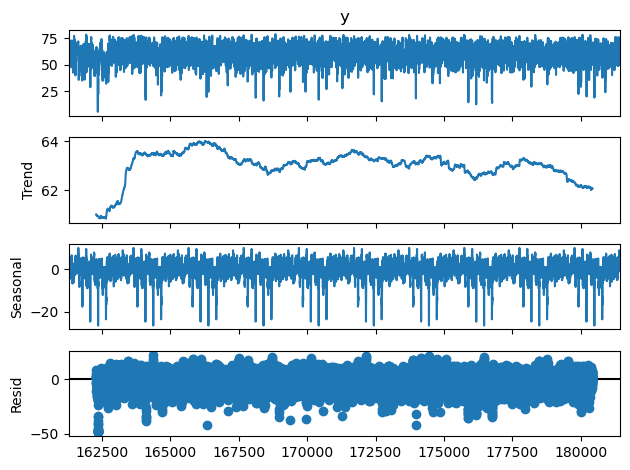

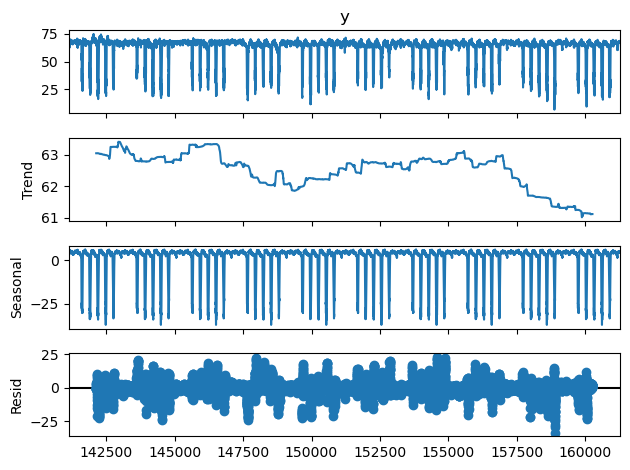

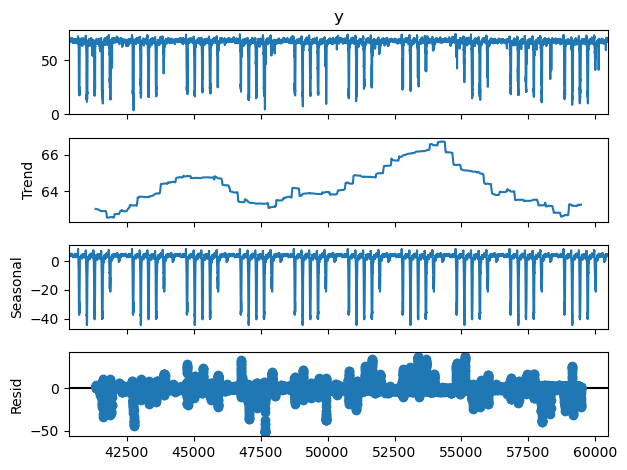

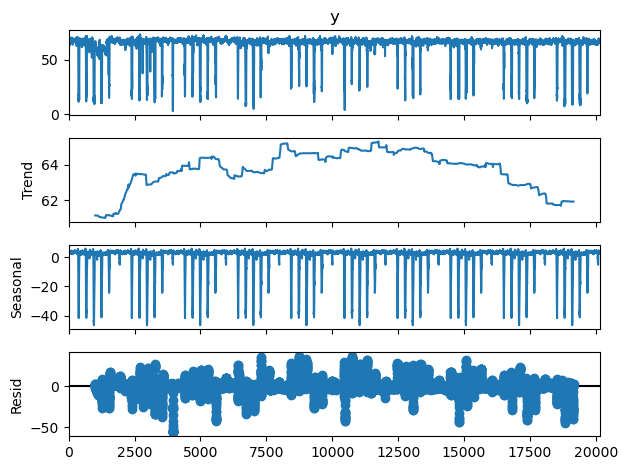

In [9]:
#Plotting the decomposition into seasonal, trend and residual parts

for sensor in sensors:
    decomposed=seasonal_decompose(sfdf(df_train).loc[sfdf(df_train)['unique_id']==sensor]["y"], model = "add", period=2016)
    decomposed.plot()
    plt.rcParams['lines.linewidth'] = 1.5
    plt.show()

In [10]:
#Setting forecasting parameters
steps_num=12
pred_num=2016
ts=beginning+timedelta(weeks=train_weeks_num)

In [42]:
#First group of models: training on the base dataset
sf1 = StatsForecast(
    models=[Naive(),AutoARIMA(),SimpleExponentialSmoothingOptimized()],
    freq='5min',
    n_jobs=-1
)

sf1.fit(sfdf(df_train))

StatsForecast(models=[Naive,AutoARIMA,SESOpt])

In [43]:
#Forecasting the first group
forecasts_naive=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf1.fitted_[j, 0]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(pred_num+steps_num):
        y_past=df_tv[sensor].iloc[:train_weeks_num*2016+i-steps_num].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]
    forecasts_naive.append(forecasts_one_sensor)
    #print(j+1,'sensors done')

In [44]:
forecasts_arima=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf1.fitted_[j, 1]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(pred_num+steps_num):
        y_past=df_tv[sensor].iloc[:train_weeks_num*2016+i-steps_num].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]
    forecasts_arima.append(forecasts_one_sensor)
    #print(j+1,'sensors done')

In [45]:
forecasts_seso=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf1.fitted_[j, 2]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(pred_num+steps_num):
        y_past=df_tv[sensor].iloc[:train_weeks_num*2016+i-steps_num].to_numpy()
        prediction=model.forecast(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]
    forecasts_seso.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done


In [46]:
#Second group of models: training on the seasonal difference dataset
sf2 = StatsForecast(
    models=[Naive(),AutoARIMA(),SimpleExponentialSmoothingOptimized()],
    freq='5min',
    n_jobs=-1
)

sf2.fit(sfdf(df_train_diff))

StatsForecast(models=[Naive,AutoARIMA,SESOpt])

In [89]:
#Forecasting the second group
forecasts_naive_sd=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf2.fitted_[j, 0]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(steps_num+pred_num):
        y_past=df_tv_diff[sensor].iloc[:train_weeks_num*2016+i-steps_num].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                past=df_tv[sensor].loc[ts+timedelta(minutes=5*(i+step-steps_num-2016))]
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+past
    forecasts_naive_sd.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done


In [90]:
forecasts_arima_sd=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf2.fitted_[j, 1]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(steps_num+pred_num):
        y_past=df_tv_diff[sensor].iloc[:train_weeks_num*2016+i-steps_num].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                past=df_tv[sensor].loc[ts+timedelta(minutes=5*(i+step-steps_num-2016))]
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+past
    forecasts_arima_sd.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done


In [91]:
forecasts_seso_sd=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf2.fitted_[j, 2]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(steps_num+pred_num):
        y_past=df_tv_diff[sensor].iloc[:train_weeks_num*2016+i-steps_num].to_numpy()
        prediction=model.forecast(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                past=df_tv[sensor].loc[ts+timedelta(minutes=5*(i+step-steps_num-2016))]
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+past
    forecasts_seso_sd.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done


In [50]:
#Third group of models: training on the historical average dataset
sf3 = StatsForecast(
    models=[Naive(),AutoARIMA(),SimpleExponentialSmoothingOptimized()],
    freq='5min',
    n_jobs=-1
)

sf3.fit(sfdf(df_train_histdiff))

StatsForecast(models=[Naive,AutoARIMA,SESOpt])

In [52]:
#Forecasting the third group
forecasts_naive_h=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf3.fitted_[j, 0]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(pred_num+steps_num):
        y_past=df_tv_histdiff[sensor].iloc[:train_weeks_num*2016+i-steps_num].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+df_hist[sensor].iloc[train_weeks_num*2016+i+step-steps_num]
    forecasts_naive_h.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done


In [53]:
forecasts_arima_h=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf3.fitted_[j, 1]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(pred_num+steps_num):
        y_past=df_tv_histdiff[sensor].iloc[:train_weeks_num*2016+i-steps_num].to_numpy()
        prediction=model.forward(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+df_hist[sensor].iloc[train_weeks_num*2016+i+step-steps_num]
    forecasts_arima_h.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done


In [54]:
forecasts_seso_h=[]
for j in range(sensors_num):
    sensor=sensors[j]
    model=sf3.fitted_[j, 2]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(pred_num+steps_num):
        y_past=df_tv_histdiff[sensor].iloc[:train_weeks_num*2016+i-steps_num].to_numpy()
        prediction=model.forecast(y_past,steps_num)['mean']
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+df_hist[sensor].iloc[train_weeks_num*2016+i+step-steps_num]
    forecasts_seso_h.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done


In [51]:
#Forecasing using the historical average
forecasts_ha=[]
for j in range(sensors_num):
    sensor=sensors[j]
    forecasts_one_sensor=np.zeros([pred_num,steps_num])
    for i in range(pred_num+steps_num):
        for step in range(steps_num):
            if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                forecasts_one_sensor[i+step-steps_num][step]=df_hist[sensor].iloc[train_weeks_num*2016+i+step-steps_num]
    forecasts_ha.append(forecasts_one_sensor)
    print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done


In [22]:
#Preparing the information for ARIMAX model
neighbors_num=4
neighbors_orders=[]
neighbors=[]
for i in range(total_sensor_num):
    sorted_orders=sorted(range(total_sensor_num),key=lambda j: dist[i][j])
    j=1
    neighbors_orders_one_sensor=[]
    neighbors_one_sensor=[]
    Dir=meta['Dir'].iloc[i]
    for j in range(1,total_sensor_num):
        if Dir=='N':
            if meta['Dir'].iloc[sorted_orders[j]]!='S':
                neighbors_orders_one_sensor.append(sorted_orders[j])
                neighbors_one_sensor.append(df.columns[sorted_orders[j]])
        elif Dir=='W':
            if meta['Dir'].iloc[sorted_orders[j]]!='E':
                neighbors_orders_one_sensor.append(sorted_orders[j])
                neighbors_one_sensor.append(df.columns[sorted_orders[j]])
        elif Dir=='E':
            if meta['Dir'].iloc[sorted_orders[j]]!='W':
                neighbors_orders_one_sensor.append(sorted_orders[j])
                neighbors_one_sensor.append(df.columns[sorted_orders[j]])
        elif Dir=='S':
            if meta['Dir'].iloc[sorted_orders[j]]!='N':
                neighbors_orders_one_sensor.append(sorted_orders[j])
                neighbors_one_sensor.append(df.columns[sorted_orders[j]])
        if len(neighbors_orders_one_sensor)==neighbors_num:
            break
    neighbors_orders.append(neighbors_orders_one_sensor)
    neighbors.append(neighbors_one_sensor)

In [55]:
#Fourth group of models: ARIMAX model on historical average
sf4 = StatsForecast(
    models=[AutoARIMA()],
    freq='5min',
    n_jobs=-1
)
forecasts_arima_hX=[]
for block in range(blocks_num):
    sensors_block=sensors[block*sensors_num_block:(block+1)*sensors_num_block]
    sf4.fit(sfdfX(df_train_all_histdiff,df_train_histdiff[sensors_block]))
    for k in range(sensors_num_block):
        j=k+block*sensors_num_block
        sensor=sensors[j]
        model=sf4.fitted_[k, 0]
        forecasts_one_sensor=np.zeros([pred_num,steps_num])
        for i in range(steps_num+pred_num):
            y_past=df_tv_histdiff[sensor].iloc[:train_weeks_num*2016+i-steps_num].to_numpy()
            X_past=df_tv_all_histdiff[neighbors[j]].iloc[:train_weeks_num*2016+i-steps_num].to_numpy()
            X_future=df_tv_all_histdiff[neighbors[j]].iloc[train_weeks_num*2016+i-steps_num:train_weeks_num*2016+i+1].to_numpy()
            prediction=model.forward(y_past,steps_num,X=X_past,X_future=X_future)['mean']
            for step in range(steps_num):
                if (i+step>=steps_num) and (i+step<pred_num+steps_num):
                    forecasts_one_sensor[i+step-steps_num][step]=prediction[step]+df_hist[sensor].iloc[train_weeks_num*2016+i+step-steps_num]
        forecasts_arima_hX.append(forecasts_one_sensor)
        print(j+1,'sensors done')

1 sensors done
2 sensors done
3 sensors done
4 sensors done
5 sensors done
6 sensors done
7 sensors done
8 sensors done
9 sensors done
10 sensors done
11 sensors done
12 sensors done
13 sensors done
14 sensors done
15 sensors done
16 sensors done
17 sensors done
18 sensors done
19 sensors done
20 sensors done


In [95]:
#Computing rmses
rmses=[]
all_forecasts=[forecasts_naive,forecasts_arima,forecasts_seso,forecasts_naive_sd,forecasts_arima_sd,forecasts_seso_sd,forecasts_naive_h,forecasts_arima_h,forecasts_seso_h,forecasts_arima_hX,forecasts_ha]
for j in range(sensors_num):
    rmses_one_sensor=[]
    actual=df_valid[sensors[j]].iloc[:pred_num]
    for step in range(steps_num):
        rmses_onestep=[]
        for forecast in all_forecasts:
            rmses_onestep.append(rmse(actual,forecast[j][:,step]))
        rmses_one_sensor.append(rmses_onestep)
    rmses.append(rmses_one_sensor)
rmses_total=[]
for step in range(steps_num):
    rmses_onestep=[]
    for i in range(len(all_forecasts)):
        rmses_onestep.append(np.array(rmses)[:,step,i].mean())
    rmses_total.append(rmses_onestep)
rmses.append(rmses_total)

In [96]:
titles=['Naive','ARIMA','SESO','Naive_sd','ARIMA_sd','SESO_sd','Naive_h','ARIMA_h','SESO_h','ARIMA_hX','HA']
for j in range(sensors_num):
    print('Sensor',j+1)
    print(pd.DataFrame(rmses[j],columns=titles))
print('Total')
print(pd.DataFrame(rmses[sensors_num],columns=titles))

Sensor 1
       Naive     ARIMA      SESO  Naive_sd  ARIMA_sd   SESO_sd   Naive_h  \
0   2.570827  2.595647  2.499277  8.617212  8.075576  8.528838  2.665458   
1   3.242142  3.231403  3.132211  8.617251  7.507561  8.528751  3.333130   
2   3.656707  3.603578  3.534808  8.617509  7.013371  8.528409  3.733392   
3   3.952787  3.846499  3.837451  8.616288  6.594992  8.527397  3.983484   
4   4.247286  4.096615  4.110461  8.616884  6.258068  8.527077  4.236784   
5   4.403345  4.195560  4.293351  8.617104  5.992857  8.526085  4.346728   
6   4.624410  4.356929  4.523143  8.612270  5.784530  8.522476  4.512571   
7   4.848598  4.519978  4.749397  8.611639  5.628791  8.521797  4.680380   
8   5.052713  4.660404  4.958871  8.610862  5.511780  8.521400  4.819185   
9   5.258331  4.800570  5.162967  8.610988  5.424896  8.521966  4.931450   
10  5.448262  4.925587  5.346221  8.613274  5.361951  8.523674  5.020472   
11  5.597682  5.011060  5.498102  8.615016  5.315851  8.524083  5.042015   

  

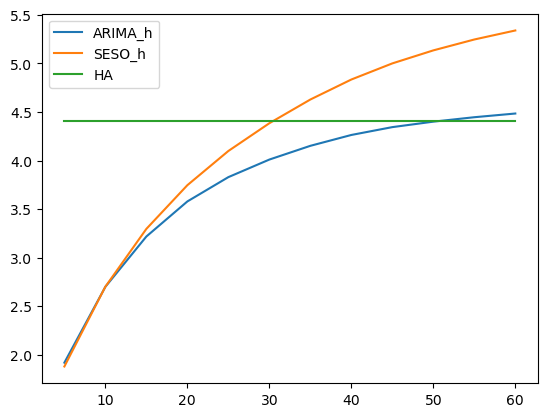

In [150]:
#Plotting the average rmse of different models depending on the predicting time into the future
plt.plot(5*np.arange(1,13),np.array(rmses[-1])[:,7],label='ARIMA_h')
plt.plot(5*np.arange(1,13),np.array(rmses[-1])[:,8],label='SESO_h')
plt.plot(5*np.arange(1,13),np.array(rmses[-1])[:,10],label='HA')
plt.legend()

In [105]:
#Finding the best model for each sensor and timestep
cols=avg_speed.columns
best_sensors=[]
for step in range(steps_num):
    rows=[]
    for sens in range(sensors_num):
        actual=df_valid[sensors[sens]].iloc[:pred_num]
        row={c:0 for c in cols}
        for pred in range(pred_num):
            arr=[abs(all_forecasts[model][sens][pred][step]-actual[pred]) for model in range(len(titles))]
            row[cols[pred]]=titles[arr.index(min(arr))]
        row['Latitude']=meta['Latitude'].iloc[sensors_orders[sens]]
        row['Longitude']=meta['Longitude'].iloc[sensors_orders[sens]]
        rows.append(row)
    best_models.append(pd.DataFrame(rows))

C:\Users\Tom\AppData\Local\Temp\ipykernel_14680\3866231745.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[cols[pred]]=[actual[pred],[all_forecasts[model][sens][pred][step]for model in range(len(titles))]]


In [147]:
cols=avg_speed_weekday.columns
best_models_weekday=[]
for step in range(steps_num):
    rows=[]
    for sens in range(sensors_num):
        actual=df_valid[sensors[sens]].iloc[:pred_num]
        row={c:0 for c in cols}
        for pred in range(288):
            arr=[abs(np.array([all_forecasts[model][sens][pred+day*288][step] for day in range(1,6)]).mean()-np.array([actual[pred+day*288] for day in range(1,6)]).mean()) for model in range(len(titles))]
            row[cols[pred]]=titles[arr.index(min(arr))]
        row['Latitude']=meta['Latitude'].iloc[sensors_orders[sens]]
        row['Longitude']=meta['Longitude'].iloc[sensors_orders[sens]]
        rows.append(row)
    best_models_weekday.append(pd.DataFrame(rows))
    best_models_weekday[step]['sensor_id']=sensors

C:\Users\Tom\AppData\Local\Temp\ipykernel_14680\3741166245.py:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [145]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(best_models_weekday[0]) 

,00:00,00:05,00:10,00:15,00:20,00:25,00:30,00:35,00:40,00:45,00:50,00:55,01:00,01:05,01:10,01:15,01:20,01:25,01:30,01:35,01:40,01:45,01:50,01:55,02:00,02:05,02:10,02:15,02:20,02:25,02:30,02:35,02:40,02:45,02:50,02:55,03:00,03:05,03:10,03:15,03:20,03:25,03:30,03:35,03:40,03:45,03:50,03:55,04:00,04:05,04:10,04:15,04:20,04:25,04:30,04:35,04:40,04:45,04:50,04:55,05:00,05:05,05:10,05:15,05:20,05:25,05:30,05:35,05:40,05:45,05:50,05:55,06:00,06:05,06:10,06:15,06:20,06:25,06:30,06:35,06:40,06:45,06:50,06:55,07:00,07:05,07:10,07:15,07:20,07:25,07:30,07:35,07:40,07:45,07:50,07:55,08:00,08:05,08:10,08:15,08:20,08:25,08:30,08:35,08:40,08:45,08:50,08:55,09:00,09:05,09:10,09:15,09:20,09:25,09:30,09:35,09:40,09:45,09:50,09:55,10:00,10:05,10:10,10:15,10:20,10:25,10:30,10:35,10:40,10:45,10:50,10:55,11:00,11:05,11:10,11:15,11:20,11:25,11:30,11:35,11:40,11:45,11:50,11:55,12:00,12:05,12:10,12:15,12:20,12:25,12:30,12:35,12:40,12:45,12:50,12:55,13:00,13:05,13:10,13:15,13:20,13:25,13:30,13:35,13:40,13:45,13:50,13:55,14:00,14:05,14:10,14:15,14:20,14:25,14:30,14:35,14:40,14:45,14:50,14:55,15:00,15:05,15:10,15:15,15:20,15:25,15:30,15:35,15:40,15:45,15:50,15:55,16:00,16:05,16:10,16:15,16:20,16:25,16:30,16:35,16:40,16:45,16:50,16:55,17:00,17:05,17:10,17:15,17:20,17:25,17:30,17:35,17:40,17:45,17:50,17:55,18:00,18:05,18:10,18:15,18:20,18:25,18:30,18:35,18:40,18:45,18:50,18:55,19:00,19:05,19:10,19:15,19:20,19:25,19:30,19:35,19:40,19:45,19:50,19:55,20:00,20:05,20:10,20:15,20:20,20:25,20:30,20:35,20:40,20:45,20:50,20:55,21:00,21:05,21:10,21:15,21:20,21:25,21:30,21:35,21:40,21:45,21:50,21:55,22:00,22:05,22:10,22:15,22:20,22:25,22:30,22:35,22:40,22:45,22:50,22:55,23:00,23:05,23:10,23:15,23:20,23:25,23:30,23:35,23:40,23:45,23:50,23:55,Latitude,Longitude,sensor_id
0,SESO_h,ARIMA_hX,SESO,Naive_h,HA,SESO,HA,ARIMA_hX,ARIMA,HA,ARIMA_hX,ARIMA_hX,ARIMA_h,SESO_h,HA,ARIMA_h,HA,SESO,SESO,ARIMA_hX,Naive_h,Naive,HA,Naive,HA,SESO,SESO,Naive_h,HA,SESO_h,ARIMA_hX,SESO_h,Naive_h,ARIMA_hX,ARIMA,ARIMA_hX,ARIMA_h,HA,HA,ARIMA,SESO,Naive_h,ARIMA_h,ARIMA_hX,HA,ARIMA_hX,ARIMA_h,HA,ARIMA_hX,HA,SESO_h,ARIMA,Naive_h,SESO,HA,ARIMA_hX,ARIMA_h,ARIMA,HA,Naive_h,Naive,ARIMA_hX,HA,ARIMA,HA,ARIMA_hX,SESO,Naive,SESO_h,ARIMA_hX,ARIMA,ARIMA_h,ARIMA_hX,ARIMA_hX,HA,SESO,ARIMA_hX,Naive,HA,SESO_h,HA,Naive,SESO,HA,ARIMA,HA,HA,SESO,HA,SESO_h,HA,SESO_h,ARIMA,HA,SESO,Naive,SESO,HA,SESO_h,ARIMA_h,HA,SESO_h,HA,SESO,HA,SESO,HA,ARIMA_hX,SESO_h,SESO,SESO_h,SESO_h,ARIMA,ARIMA,HA,HA,SESO_h,HA,ARIMA_h,ARIMA_hX,HA,SESO_h,HA,SESO_h,ARIMA,Naive_h,Naive_h,ARIMA,HA,Naive_h,HA,ARIMA,SESO,ARIMA_hX,ARIMA,ARIMA_hX,ARIMA_h,SESO,ARIMA_h,SESO_h,ARIMA_hX,ARIMA,SESO_h,ARIMA_h,HA,SESO,Naive,SESO,SESO_h,SESO,SESO,ARIMA_hX,ARIMA,Naive_h,SESO_h,HA,SESO,SESO,HA,ARIMA,ARIMA_hX,SESO_h,ARIMA_hX,HA,ARIMA_h,Naive,HA,SESO_h,SESO_h,ARIMA,SESO,Naive,SESO_h,ARIMA_hX,SESO_h,HA,ARIMA_hX,ARIMA_hX,ARIMA_hX,Naive_h,ARIMA_sd,ARIMA_hX,ARIMA_sd,Naive,Naive,ARIMA,ARIMA,Naive_h,SESO_h,ARIMA_h,Naive,ARIMA_hX,SESO,ARIMA_hX,ARIMA,ARIMA_h,HA,HA,ARIMA_hX,ARIMA_hX,ARIMA_hX,Naive,ARIMA,SESO_h,Naive,ARIMA,SESO_h,HA,SESO_h,HA,Naive,ARIMA_hX,HA,HA,ARIMA,HA,SESO_h,SESO,Naive,SESO,HA,HA,SESO,Naive_h,ARIMA,ARIMA,ARIMA,Naive,ARIMA_hX,ARIMA_h,SESO,HA,ARIMA_hX,ARIMA_h,Naive_h,HA,ARIMA_hX,ARIMA,ARIMA,ARIMA,HA,SESO_h,SESO_h,SESO,SESO,SESO,ARIMA,ARIMA_h,Naive_h,SESO,SESO,HA,SESO_h,SESO_h,ARIMA_h,SESO,SESO_h,SESO,SESO,HA,SESO,SESO,SESO_h,SESO_h,SESO,ARIMA_h,SESO_h,HA,SESO_h,SESO_h,HA,HA,SESO_h,ARIMA_sd,ARIMA_sd,SESO_h,HA,HA,SESO_h,ARIMA_hX,HA,Naive_h,SESO_h,ARIMA_hX,HA,HA,Naive,HA,37.401893,-122.041683,403412
1,ARIMA_hX,ARIMA,SESO_h,SESO_sd,HA,ARIMA_hX,HA,SESO_h,HA,ARIMA_hX,ARIMA_sd,ARIMA_sd,ARIMA_h,SESO_h,ARIMA_hX,HA,HA,ARIMA_sd,HA,HA,SESO,HA,ARIMA_sd,HA,ARIMA,Naive,HA,ARIMA_hX,ARIMA,HA,SESO_sd,HA,HA,ARIMA,Naive_sd,HA,HA,SESO,ARIMA,SESO_sd,HA,Naive_h,ARIMA_sd,SESO,SESO_sd,ARIMA_sd,HA,ARIMA,ARIMA_hX,HA,SESO_h,ARIMA_sd,SESO_h,SESO_sd,HA,ARIMA_hX,Naive,ARIMA_sd,ARIMA_hX,SESO,ARIMA_h,Naive,SESO_h,SESO_sd,SESO_sd,ARIMA_hX,HA,ARIMA,ARIMA_hX,Naive_sd,ARIMA_sd,ARIMA,Naive,ARIM

In [148]:
#Making an animated map of the best model
best_models_weekday_long=best_models_weekday[0].melt(
    id_vars=['sensor_id','Latitude','Longitude'],
    value_vars=[c for c in best_models_weekday[0].columns if c not in ['sensor_id','Latitude','Longitude']],
    var_name='time_str',
    value_name='best_model',
)
color_map={
    'Naive':'#ffcccc',
    'ARIMA':'#ccffcc',
    'SESO':'#ccccff',
    'Naive_sd':'#ff0000',
    'ARIMA_sd':'#00ff00',
    'SESO_sd':'#0000ff',
    'Naive_h':'#cc0000',
    'ARIMA_h':'#00cc00',
    'SESO_h':'#00000c',
    'ARIMA_hX':'#000000',
    'HA':'#777777',
}
fig = px.scatter_mapbox(
    best_models_weekday_long,
    lat="Latitude",
    lon="Longitude",
    color="best_model",
    animation_frame="time_str",
    animation_group="sensor_id",
    color_discrete_map=color_map,
    hover_name="sensor_id",
    hover_data={"best_model":":.2f", "Latitude":False, "Longitude":False},
    mapbox_style="open-street-map",
    zoom=11,
    height=750,
)
fig.update_traces(marker=dict(size=14))
fig.write_html("best_model_animation_weekday.html", auto_play=False)

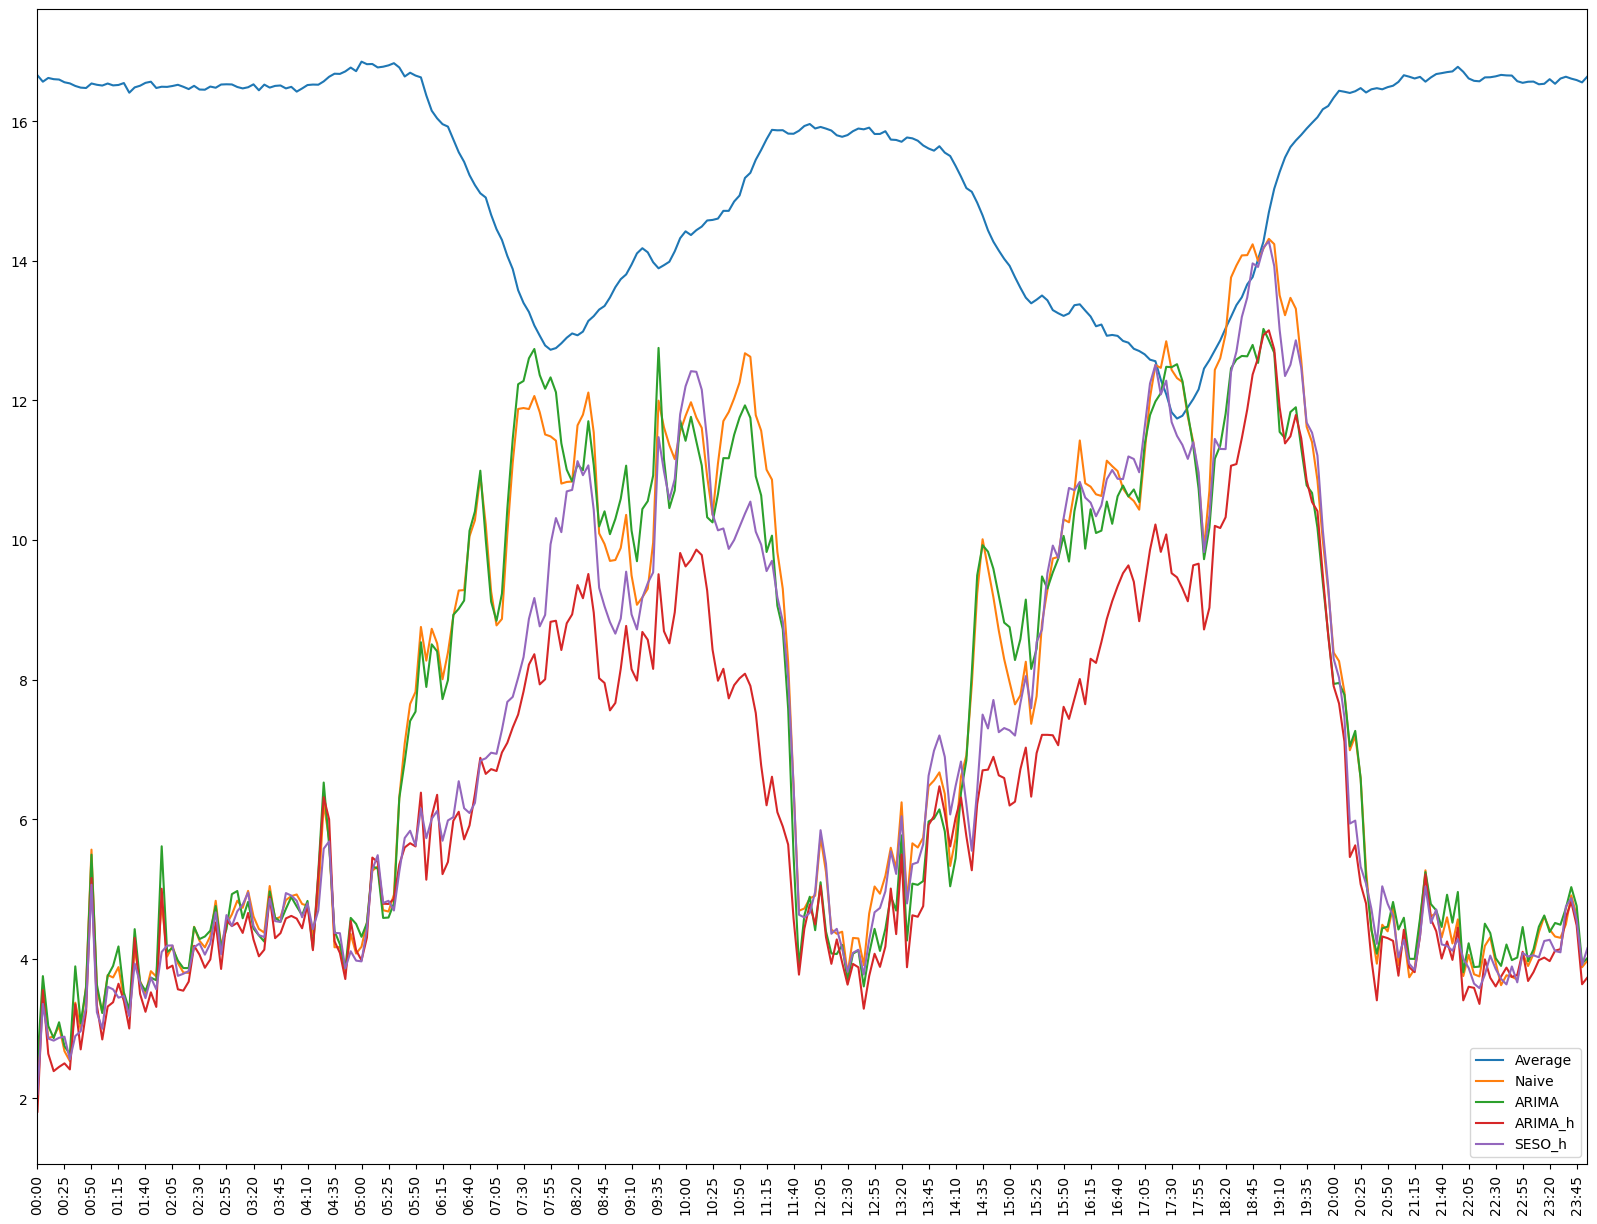

In [168]:
#Computing the average speed for all timeslots throughout the week
avgg=np.array([df_valid[sensors[i]] for i in range(sensors_num)]).mean(axis=0)
avgg_weekday=np.array([avgg[i+288]+avgg[i+288*2]+avgg[i+288*3]+avgg[i+288*4]+avgg[i+288*5] for i in range(288)])
avgg_weekend=np.array([avgg[i]+avgg[i+288*6] for i in range(288)])


#Plotting the average rmse of models as a function of time during a day

def mm_to_hhmm(x, pos=None):
    h = int(x) // 60
    m = int(x) % 60
    return f"{h:02d}:{m:02d}"

fig, ax = plt.subplots(figsize=(20,15))
# ax.plot(x_minutes, y)

ax.set_xlim(0, 23*60 + 55)
ax.xaxis.set_major_locator(mticker.MultipleLocator(25))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(mm_to_hhmm))
plt.setp(ax.get_xticklabels(), rotation=90)
x_minutes = np.arange(0, 24 * 60, 5)
times = pd.date_range('2025-01-01 00:00', '2025-01-01 23:55', freq='5min')


difs=[]
for step in range(steps_num):
    difs_one_step=[]
    for i in range(len(titles)):
        difs_one_step.append(np.array([(df_tv[sensors[j]].iloc[:pred_num]-all_forecasts[i][j][:,step])**2 for j in range(sensors_num)]).mean(axis=0)**0.5)
    difs.append(difs_one_step)

difs_weekday=[]
for step in range(steps_num):
    difs_one_step=[]
    for i in range(len(titles)):
        day1=np.array([(df_tv[sensors[j]].iloc[288:288*2]-all_forecasts[i][j][288:288*2,step])**2 for j in range(sensors_num)])
        day2=np.array([(df_tv[sensors[j]].iloc[288*2:288*3]-all_forecasts[i][j][288*2:288*3,step])**2 for j in range(sensors_num)])
        day3=np.array([(df_tv[sensors[j]].iloc[288*3:288*4]-all_forecasts[i][j][288*3:288*4,step])**2 for j in range(sensors_num)])
        day4=np.array([(df_tv[sensors[j]].iloc[288*4:288*5]-all_forecasts[i][j][288*4:288*5,step])**2 for j in range(sensors_num)])
        day5=np.array([(df_tv[sensors[j]].iloc[288*5:288*6]-all_forecasts[i][j][288*5:288*6,step])**2 for j in range(sensors_num)])
        difs_one_step.append(((day1+day2+day3+day4+day5)*0.2).mean(axis=0)**0.5)
    difs_weekday.append(difs_one_step)

difs_weekend=[]
for step in range(steps_num):
    difs_one_step=[]
    for i in range(len(titles)):
        day1=np.array([(df_tv[sensors[j]].iloc[:288]-all_forecasts[i][j][:288,step])**2 for j in range(sensors_num)])
        day2=np.array([(df_tv[sensors[j]].iloc[288*6:288*7]-all_forecasts[i][j][288*6:288*7,step])**2 for j in range(sensors_num)])
        difs_one_step.append(((day1+day2)*0.5).mean(axis=0)**0.5)
    difs_weekend.append(difs_one_step)

step=5
ax.plot(x_minutes,avgg_weekday/20,label='Average')
ax.plot(x_minutes,difs_weekday[step][0],label='Naive')
ax.plot(x_minutes,difs_weekday[step][1],label='ARIMA')
ax.plot(x_minutes,difs_weekday[step][7],label='ARIMA_h')
ax.plot(x_minutes,difs_weekday[step][8],label='SESO_h')

plt.legend()
